# 咽部分类

## 模块导入

In [2]:
import os
import sys
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

import shutil
import random
import glob
import pandas as pd
import cv2
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import MobileNetV2, MobileNet
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.optimizers import SGD,Adam
import tensorflow as tf

# 添加路径，以能正常导入mbsh、trainer
sys.path.insert(0, r"..\Lib\trainer")

from mbsh.core.images import fetch_all_files, read_img_file, resize_image,save_img_file

from mbsh import create_app
from mbsh.core.models import SmallModel
from mbsh.core.images import read_to_pd,TrainArgs
from mbsh.core.plot import Plot

from trainer import Trainer

2022-07-04 15:03:58,313 - INFO - __init__.py - init_logger - 58 - ini  logger file D:\projects\Vision\Lib\logs\kernel-9b619b66-6c82-432a-9e19-cfc422b61f05.log


use temp dir:d:\znyx\temp


In [3]:
## 训练配置
# 样本数据根目录
# 根目录下res中按分类标签存放各类型图像
# cache目录存放训练的结果模型

root_path = r"\\192.168.0.154\数据\口咽部\第8轮"
""
#是否使用平衡数据做训练
use_increase = False

#训练采用的模型名称
model_name = 'resnet'

unfreeze_layers = 179

# 模型保存id
model_id = 2801

# 数据库中记录条目的name
# sm_name = '喉-上颚-咽后壁-右梨状窝-左梨状窝'
# 如果数据库还未建立相应的记录可查询一个已存在的，再自行修改sm的desc_list

# sm_desc_list =  ["喉","上颚","咽后壁","右梨状窝","左梨状窝"]
sm_name = 'ca'
sm_desc_list =  ["喉","上颚","咽后壁","右梨状窝","左梨状窝"]
sm = SmallModel(sm_name)

# 数据划分为验证集的比例
split_ratio = 0.15

#过程尺寸
# img_process_size = (480,480)

# 训练图像大小，默认是(224,224)
img_size = (224,224)

# img_size = (360,360)
# 训练迭代次数
epochs = 20
## 训练配置
# 训练每批次样本数
batch_size = 16

## 初始化

In [4]:
# app创建
app = create_app(os.getenv('FLASK_CONFIG') or 'default')
app.app_context().push()

2022-07-04 15:04:02,874 - INFO - __init__.py - create_app - 71 - db url =sqlite:///D:\projects\Vision\Lib\trainer\../data\production.db


In [5]:
cache_path = root_path + '/cache'
res_path = root_path + '/res'

# res数据分割后的训练和验证集目录
res_train_path = root_path + '/res_train'
res_test_path = root_path + '/res_val'

# 数据平衡后的训练和验证集目录
train_path = root_path + '/train'
test_path = root_path + '/test'
cache_path
# 图片预测错误存放目录
pred_err_path = root_path + '/pred_err_resnet50'

# trainer创建

# 从数据库获取model信息，如果数据库还未建立相应的记录可查询一个已存在的，再自行修改sm的desc_list
# sm = SmallModel.query.get(sm_name)

sm = SmallModel(sm_name)
sm.desc_list = sm_desc_list
trainer = Trainer(sm)
trainer.img_size = img_size
trainer.target_fold = root_path

# 类型个数
types_num = len(trainer.desc_list)

desc_list = [str(x) + '-' + trainer.desc_list[x] for x in range(0,types_num)]
print(desc_list)

['0-喉', '1-上颚', '2-咽后壁', '3-右梨状窝', '4-左梨状窝']


## ResNet推理

D:\Anaconda3\lib\site-packages\keras\backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '
2022-07-04 15:04:16,090 - DEBUG - attrs.py - __getitem__ - 77 - Creating converter from 3 to 5
2022-07-04 15:04:17,697 - INFO - trainer.py - load_model - 545 - load weights 50
2022-07-04 15:04:17,698 - DEBUG - images.py - sort_by_file_name - 354 - sort_by_file_name dirs=['0', '1', '2', '3', '4']


find 5 from \\192.168.0.154\数据\口咽部\第8轮\valid_date_结果\奥巴
load data from fold finished ,count=175
6/6 [==============================] - 13s 140ms/step


2022-07-04 15:04:34,389 - DEBUG - font_manager.py - _findfont_cached - 1329 - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2022-07-04 15:04:34,390 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='D:\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-07-04 15:04:34,391 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='D:\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneralBolIta.ttf', name='STIXGeneral', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-07-04 15:04:34,392 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='D:\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-Obli

2022-07-04 15:04:34,409 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='D:\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-07-04 15:04:34,410 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='D:\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:34,411 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='D:\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:34,411 - DEBUG - font_manager.p

cast-330ms, fold: ['\\\\192.168.0.154\\数据\\口咽部\\第8轮\\valid_date_结果\\奥巴'] ,accurracy:88


2022-07-04 15:04:34,420 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ariali.ttf', name='Arial', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-07-04 15:04:34,420 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\REFSAN.TTF', name='MS Reference Sans Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:34,421 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\STLITI.TTF', name='STLiti', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:34,422 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CENTURY.TTF', name='Century', style='normal', variant='normal', weight=400, stretch='normal', size='scalab

2022-07-04 15:04:34,441 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\palabi.ttf', name='Palatino Linotype', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-07-04 15:04:34,442 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\verdanaz.ttf', name='Verdana', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-07-04 15:04:34,442 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GOTHICI.TTF', name='Century Gothic', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-07-04 15:04:34,443 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\verdanai.ttf', name='Verdana', style='italic', variant='normal', weight=400, stretch='normal', si

2022-07-04 15:04:34,465 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\corbell.ttf', name='Corbel', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
2022-07-04 15:04:34,466 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOTHICBI.TTF', name='Century Gothic', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-07-04 15:04:34,467 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\phagspa.ttf', name='Microsoft PhagsPa', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:34,467 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Candarab.ttf', name='Candara', style='normal', variant='normal', weight=700, stretch='normal', si

2022-07-04 15:04:34,489 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\segoeuil.ttf', name='Segoe UI', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
2022-07-04 15:04:34,490 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\STKAITI.TTF', name='STKaiti', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:34,491 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Gabriola.ttf', name='Gabriola', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:34,491 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\cour.ttf', name='Courier New', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')

2022-07-04 15:04:34,513 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SitkaB.ttc', name='Sitka Small', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-07-04 15:04:34,513 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\verdanab.ttf', name='Verdana', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-07-04 15:04:34,514 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\corbelz.ttf', name='Corbel', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-07-04 15:04:34,515 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\msyhl.ttc', name='Microsoft YaHei', style='normal', variant='normal', weight=290, stretch='normal', size='scal

2022-07-04 15:04:34,536 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ANTQUAB.TTF', name='Book Antiqua', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-07-04 15:04:34,537 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\YuGothR.ttc', name='Yu Gothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:34,538 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\taile.ttf', name='Microsoft Tai Le', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:34,538 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\segoepr.ttf', name='Segoe Print', style='normal', variant='normal', weight=400, stretch='normal', siz

2022-07-04 15:04:34,559 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\comic.ttf', name='Comic Sans MS', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:34,560 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Deng.ttf', name='DengXian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:34,560 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\verdanai.ttf', name='Verdana', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-07-04 15:04:34,561 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segmdl2.ttf', name='Segoe MDL2 Assets', style='normal', variant='normal', weight=400, stretch='normal', size='sca

2022-07-04 15:04:34,582 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\wingding.ttf', name='Wingdings', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:34,583 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Sitka.ttc', name='Sitka Small', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:34,584 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\DUBAI-MEDIUM.TTF', name='Dubai', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
2022-07-04 15:04:34,585 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\simkai.ttf', name='KaiTi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')

2022-07-04 15:04:34,605 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\seguisym.ttf', name='Segoe UI Symbol', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:34,606 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\seguili.ttf', name='Segoe UI', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
2022-07-04 15:04:34,606 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\couri.ttf', name='Courier New', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-07-04 15:04:34,607 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguiemj.ttf', name='Segoe UI Emoji', style='normal', variant='normal', weight=400, stretch='normal', s

2022-07-04 15:04:34,628 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\micross.ttf', name='Microsoft Sans Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:34,629 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\framdit.ttf', name='Franklin Gothic Medium', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-07-04 15:04:34,630 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FZSTK.TTF', name='FZShuTi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:34,630 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\cambria.ttc', name='Cambria', style='normal', variant='normal', weight=400, stretch='norma

2022-07-04 15:04:34,651 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\STFANGSO.TTF', name='STFangsong', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:34,652 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeuisl.ttf', name='Segoe UI', style='normal', variant='normal', weight=350, stretch='normal', size='scalable')) = 10.0975
2022-07-04 15:04:34,653 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\trebucbi.ttf', name='Trebuchet MS', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-07-04 15:04:34,653 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\FZSTK.TTF', name='FZShuTi', style='normal', variant='normal', weight=400, stretch='normal', size='sc

2022-07-04 15:04:34,674 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\segoeuii.ttf', name='Segoe UI', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-07-04 15:04:34,675 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\courbd.ttf', name='Courier New', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-07-04 15:04:34,675 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\DUBAI-BOLD.TTF', name='Dubai', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-07-04 15:04:34,676 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\pala.ttf', name='Palatino Linotype', style='normal', variant='normal', weight=400, stretch='normal', size='s

2022-07-04 15:04:34,696 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ZWAdobeF.TTF', name='ZWAdobeF', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:34,697 - DEBUG - font_manager.py - _findfont_cached - 1367 - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to SimHei ('C:\\Windows\\Fonts\\simhei.ttf') with score of 0.050000.
2022-07-04 15:04:34,738 - DEBUG - colorbar.py - _get_ticker_locator_formatter - 847 - locator: <matplotlib.ticker.AutoLocator object at 0x000001C96CD55DC0>
2022-07-04 15:04:34,753 - DEBUG - font_manager.py - _findfont_cached - 1329 - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2022-07-04 15:04:34,754 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='D:\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\f

2022-07-04 15:04:34,770 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='D:\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:34,771 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='D:\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:34,771 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='D:\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-07-04 15:04:34,772 - DEBUG - font_manager.py - _findfont_cached - 1341 - fin

2022-07-04 15:04:34,791 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\msjhbd.ttc', name='Microsoft JhengHei', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-07-04 15:04:34,792 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ANTQUABI.TTF', name='Book Antiqua', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-07-04 15:04:34,792 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\malgun.ttf', name='Malgun Gothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:34,793 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\simfang.ttf', name='FangSong', style='normal', variant='normal', weight=400, stretch='normal'

2022-07-04 15:04:34,814 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Candaraz.ttf', name='Candara', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-07-04 15:04:34,815 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SIMLI.TTF', name='LiSu', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:34,815 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\simhei.ttf', name='SimHei', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.05
2022-07-04 15:04:34,816 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Dengl.ttf', name='DengXian', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
20

2022-07-04 15:04:34,837 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\STXINWEI.TTF', name='STXinwei', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:34,837 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\corbel.ttf', name='Corbel', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:34,838 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Candarali.ttf', name='Candara', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-07-04 15:04:34,839 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\cambriab.ttf', name='Cambria', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) =

2022-07-04 15:04:34,860 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Program Files (x86)\\Adobe\\Acrobat DC\\Resource\\Font\\AdobeDevanagari-Bold.otf', name='Adobe Devanagari', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-07-04 15:04:34,861 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ARIALNB.TTF', name='Arial', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 10.535
2022-07-04 15:04:34,862 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\msyhbd.ttc', name='Microsoft YaHei', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-07-04 15:04:34,862 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SitkaI.ttc', name='Sitka Small', style='ita

2022-07-04 15:04:34,882 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\georgiai.ttf', name='Georgia', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-07-04 15:04:34,883 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ntailub.ttf', name='Microsoft New Tai Lue', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-07-04 15:04:34,884 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\tahoma.ttf', name='Tahoma', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:34,884 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\sylfaen.ttf', name='Sylfaen', style='normal', variant='normal', weight=400, stretch='normal', size='sc

2022-07-04 15:04:34,905 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\timesi.ttf', name='Times New Roman', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-07-04 15:04:34,905 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\georgiaz.ttf', name='Georgia', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-07-04 15:04:34,906 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOOKOSB.TTF', name='Bookman Old Style', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
2022-07-04 15:04:34,907 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\l_10646.ttf', name='Lucida Sans Unicode', style='normal', variant='normal', weight=400, stretch='

Confusion matrix, without normalization


2022-07-04 15:04:34,920 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\comic.ttf', name='Comic Sans MS', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:34,921 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Deng.ttf', name='DengXian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:34,921 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\verdanai.ttf', name='Verdana', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-07-04 15:04:34,922 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segmdl2.ttf', name='Segoe MDL2 Assets', style='normal', variant='normal', weight=400, stretch='normal', size='sca

2022-07-04 15:04:34,943 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\wingding.ttf', name='Wingdings', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:34,944 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Sitka.ttc', name='Sitka Small', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:34,944 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\DUBAI-MEDIUM.TTF', name='Dubai', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
2022-07-04 15:04:34,945 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\simkai.ttf', name='KaiTi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')

2022-07-04 15:04:34,965 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\seguisym.ttf', name='Segoe UI Symbol', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:34,966 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\seguili.ttf', name='Segoe UI', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
2022-07-04 15:04:34,967 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\couri.ttf', name='Courier New', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-07-04 15:04:34,967 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguiemj.ttf', name='Segoe UI Emoji', style='normal', variant='normal', weight=400, stretch='normal', s

2022-07-04 15:04:34,988 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\micross.ttf', name='Microsoft Sans Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:34,988 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\framdit.ttf', name='Franklin Gothic Medium', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-07-04 15:04:34,989 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FZSTK.TTF', name='FZShuTi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:34,990 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\cambria.ttc', name='Cambria', style='normal', variant='normal', weight=400, stretch='norma

2022-07-04 15:04:35,011 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\STFANGSO.TTF', name='STFangsong', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:35,012 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeuisl.ttf', name='Segoe UI', style='normal', variant='normal', weight=350, stretch='normal', size='scalable')) = 10.0975
2022-07-04 15:04:35,012 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\trebucbi.ttf', name='Trebuchet MS', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-07-04 15:04:35,013 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\FZSTK.TTF', name='FZShuTi', style='normal', variant='normal', weight=400, stretch='normal', size='sc

2022-07-04 15:04:35,036 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\segoeuii.ttf', name='Segoe UI', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-07-04 15:04:35,037 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\courbd.ttf', name='Courier New', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-07-04 15:04:35,037 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\DUBAI-BOLD.TTF', name='Dubai', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-07-04 15:04:35,038 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\pala.ttf', name='Palatino Linotype', style='normal', variant='normal', weight=400, stretch='normal', size='s

2022-07-04 15:04:35,059 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ZWAdobeF.TTF', name='ZWAdobeF', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:35,060 - DEBUG - font_manager.py - _findfont_cached - 1367 - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to SimHei ('C:\\Windows\\Fonts\\simhei.ttf') with score of 0.050000.
2022-07-04 15:04:35,124 - DEBUG - font_manager.py - _findfont_cached - 1329 - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2022-07-04 15:04:35,126 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='D:\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-07-04 1

2022-07-04 15:04:35,143 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='D:\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:35,143 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='D:\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:35,144 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='D:\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-07-04 15:04:35,145 - DEBUG - font_manager.py - _findfont_cached - 1341 - fin

2022-07-04 15:04:35,163 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\msjhbd.ttc', name='Microsoft JhengHei', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-07-04 15:04:35,164 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ANTQUABI.TTF', name='Book Antiqua', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-07-04 15:04:35,165 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\malgun.ttf', name='Malgun Gothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:35,166 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\simfang.ttf', name='FangSong', style='normal', variant='normal', weight=400, stretch='normal'

2022-07-04 15:04:35,186 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Candaraz.ttf', name='Candara', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-07-04 15:04:35,187 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SIMLI.TTF', name='LiSu', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:35,188 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\simhei.ttf', name='SimHei', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.05
2022-07-04 15:04:35,189 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Dengl.ttf', name='DengXian', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
20

2022-07-04 15:04:35,210 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\STXINWEI.TTF', name='STXinwei', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:35,210 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\corbel.ttf', name='Corbel', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:35,211 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Candarali.ttf', name='Candara', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-07-04 15:04:35,212 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\cambriab.ttf', name='Cambria', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) =

2022-07-04 15:04:35,235 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Program Files (x86)\\Adobe\\Acrobat DC\\Resource\\Font\\AdobeDevanagari-Bold.otf', name='Adobe Devanagari', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-07-04 15:04:35,236 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ARIALNB.TTF', name='Arial', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 10.535
2022-07-04 15:04:35,236 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\msyhbd.ttc', name='Microsoft YaHei', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-07-04 15:04:35,237 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SitkaI.ttc', name='Sitka Small', style='ita

2022-07-04 15:04:35,257 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\georgiai.ttf', name='Georgia', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-07-04 15:04:35,258 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ntailub.ttf', name='Microsoft New Tai Lue', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-07-04 15:04:35,259 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\tahoma.ttf', name='Tahoma', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:35,259 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\sylfaen.ttf', name='Sylfaen', style='normal', variant='normal', weight=400, stretch='normal', size='sc

2022-07-04 15:04:35,280 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\timesi.ttf', name='Times New Roman', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-07-04 15:04:35,280 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\georgiaz.ttf', name='Georgia', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-07-04 15:04:35,281 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOOKOSB.TTF', name='Bookman Old Style', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
2022-07-04 15:04:35,281 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\l_10646.ttf', name='Lucida Sans Unicode', style='normal', variant='normal', weight=400, stretch='

2022-07-04 15:04:35,305 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\YuGothL.ttc', name='Yu Gothic', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
2022-07-04 15:04:35,306 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SitkaB.ttc', name='Sitka Small', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-07-04 15:04:35,307 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\WINGDNG2.TTF', name='Wingdings 2', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:35,308 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\courbi.ttf', name='Courier New', style='italic', variant='normal', weight=700, stretch='normal', size='s

2022-07-04 15:04:35,330 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\segoeuisl.ttf', name='Segoe UI', style='normal', variant='normal', weight=350, stretch='normal', size='scalable')) = 10.0975
2022-07-04 15:04:35,331 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\mingliub.ttc', name='MingLiU-ExtB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:35,331 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LeelUIsl.ttf', name='Leelawadee UI', style='normal', variant='normal', weight=350, stretch='normal', size='scalable')) = 10.0975
2022-07-04 15:04:35,332 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\segoeuiz.ttf', name='Segoe UI', style='italic', variant='normal', weight=700, stretch='normal', 

2022-07-04 15:04:35,353 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\courbd.ttf', name='Courier New', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-07-04 15:04:35,353 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\consola.ttf', name='Consolas', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:35,354 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\msjhl.ttc', name='Microsoft JhengHei', style='normal', variant='normal', weight=290, stretch='normal', size='scalable')) = 10.1545
2022-07-04 15:04:35,355 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\WINGDNG3.TTF', name='Wingdings 3', style='normal', variant='normal', weight=400, stretch='normal', s

2022-07-04 15:04:35,375 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CENTURY.TTF', name='Century', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:35,376 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\couri.ttf', name='Courier New', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-07-04 15:04:35,377 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LeelaUIb.ttf', name='Leelawadee UI', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-07-04 15:04:35,377 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ARIALN.TTF', name='Arial', style='normal', variant='normal', weight=400, stretch='condensed', size='scalab

2022-07-04 15:04:35,398 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\comici.ttf', name='Comic Sans MS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-07-04 15:04:35,398 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\timesbi.ttf', name='Times New Roman', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-07-04 15:04:35,399 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\holomdl2.ttf', name='HoloLens MDL2 Assets', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:35,400 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Candarab.ttf', name='Candara', style='normal', variant='normal', weight=700, stretch='no

2022-07-04 15:04:35,422 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOOKOSBI.TTF', name='Bookman Old Style', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
2022-07-04 15:04:35,423 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\georgiaz.ttf', name='Georgia', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-07-04 15:04:35,424 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\simfang.ttf', name='FangSong', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-04 15:04:35,425 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\STXINGKA.TTF', name='STXingkai', style='normal', variant='normal', weight=400, stretch='normal', size=

[[68  0  0  0  0]
 [ 0 25  1  3  0]
 [ 0  0 28  0  0]
 [ 0  0  0 23  0]
 [ 5  1  0 10 11]]
00 acc: 100.00%
01 acc: 86.21%
02 acc: 100.00%
03 acc: 100.00%
04 acc: 40.74%
overall acc: 88.57%, avg acc: 85.39%


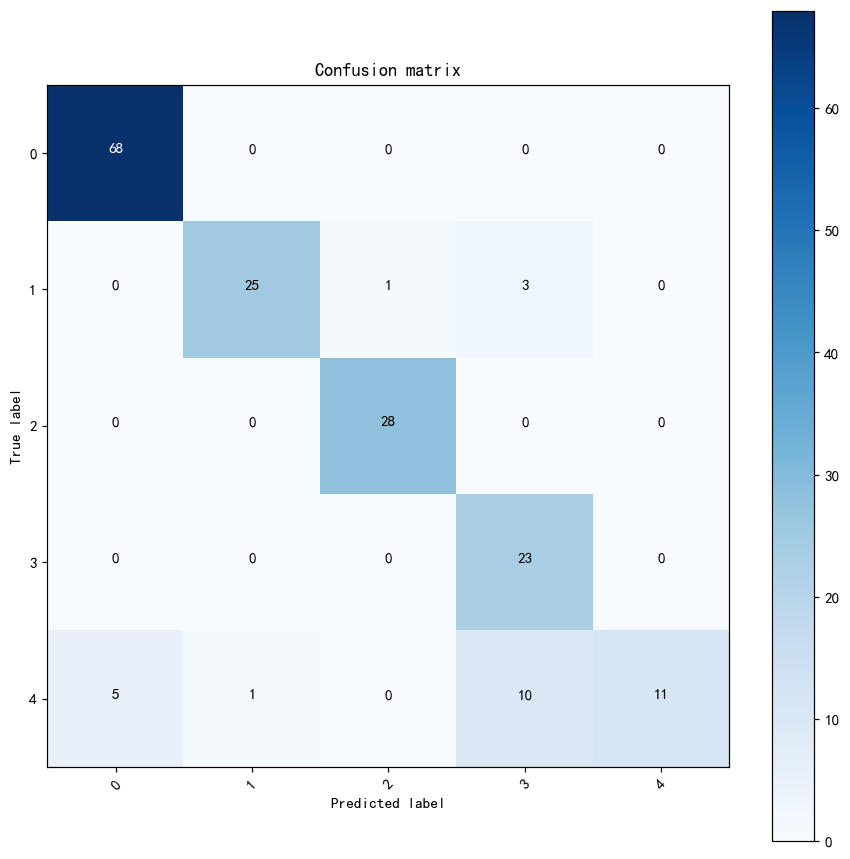

['0-喉', '1-上颚', '2-咽后壁', '3-右梨状窝', '4-左梨状窝']


In [6]:
K.set_learning_phase(0)
model = trainer.load_model(50)
# 加载训练中的最优模型
use_increase = False
# 显示预测准确度、混淆矩阵，保持混淆矩阵图到root_path
acc, y_pred, y_true, file_test,_ = trainer.predict_data([r"\\192.168.0.154\数据\口咽部\第8轮\valid_date_结果\奥巴"], model = model)

path = Plot.show_matrix(y_pred, y_true, types_num, root_path, fig_size=10)
plt.show()
print(desc_list)

D:\Anaconda3\lib\site-packages\keras\backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '
2022-07-04 15:05:30,473 - INFO - trainer.py - load_model - 545 - load weights 50
2022-07-04 15:05:30,477 - DEBUG - images.py - sort_by_file_name - 354 - sort_by_file_name dirs=['0', '1', '2', '3', '4']


find 5 from \\192.168.0.154\数据\口咽部\第8轮\valid_date_结果\富士
load data from fold finished ,count=162
6/6 [==============================] - 2s 195ms/step


2022-07-04 15:05:35,304 - DEBUG - colorbar.py - _get_ticker_locator_formatter - 847 - locator: <matplotlib.ticker.AutoLocator object at 0x000001C979E47910>
2022-07-04 15:05:35,447 - INFO - plot.py - show_matrix - 164 - save plot image to \\192.168.0.154\数据\口咽部\第8轮\2022-07-04-15-05_853.jpg 
2022-07-04 15:05:35,448 - INFO - plot.py - show_matrix - 180 - accurracy:0.8024691358024691


cast-192ms, fold: ['\\\\192.168.0.154\\数据\\口咽部\\第8轮\\valid_date_结果\\富士'] ,accurracy:80
Confusion matrix, without normalization
[[44  1  0  0  0]
 [ 0 24  1  1  0]
 [ 2  3 33  0  0]
 [ 1  1  0 21  0]
 [ 3  4  0 15  8]]
00 acc: 97.78%
01 acc: 92.31%
02 acc: 86.84%
03 acc: 91.30%
04 acc: 26.67%
overall acc: 80.25%, avg acc: 78.98%


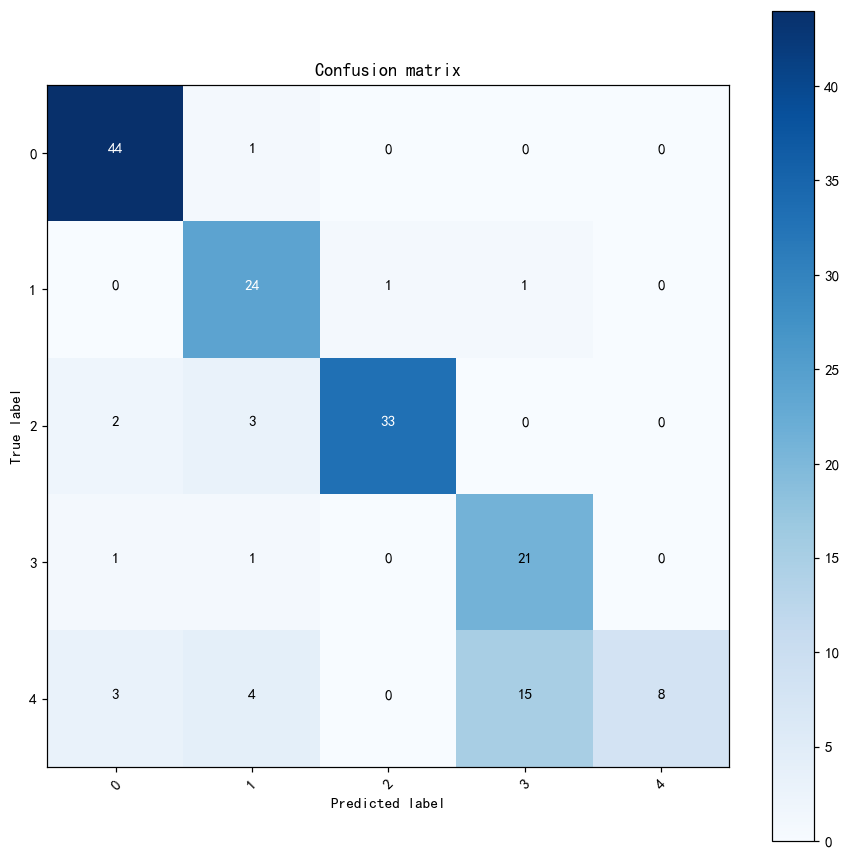

['0-喉', '1-上颚', '2-咽后壁', '3-右梨状窝', '4-左梨状窝']


In [7]:
K.set_learning_phase(0)
model = trainer.load_model(50)
# 加载训练中的最优模型
use_increase = False
# 显示预测准确度、混淆矩阵，保持混淆矩阵图到root_path
acc, y_pred, y_true, file_test,_ = trainer.predict_data([r"\\192.168.0.154\数据\口咽部\第8轮\valid_date_结果\富士"], model = model)

path = Plot.show_matrix(y_pred, y_true, types_num, root_path, fig_size=10)
plt.show()
print(desc_list)

D:\Anaconda3\lib\site-packages\keras\backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '
2022-07-04 15:12:21,533 - INFO - trainer.py - load_model - 545 - load weights 50
2022-07-04 15:12:21,537 - DEBUG - images.py - sort_by_file_name - 354 - sort_by_file_name dirs=['0', '1', '2', '3', '4']


find 5 from \\192.168.0.154\数据\口咽部\第7轮_整图\valid_date
load data from fold finished ,count=181
6/6 [==============================] - 1s 124ms/step


2022-07-04 15:12:25,690 - DEBUG - colorbar.py - _get_ticker_locator_formatter - 847 - locator: <matplotlib.ticker.AutoLocator object at 0x000001C9564EF3A0>


cast134ms, fold: ['\\\\192.168.0.154\\数据\\口咽部\\第7轮_整图\\valid_date'] ,accurracy:97
Confusion matrix, without normalization


2022-07-04 15:12:25,832 - INFO - plot.py - show_matrix - 164 - save plot image to \\192.168.0.154\数据\口咽部\第8轮\2022-07-04-15-12_240.jpg 
2022-07-04 15:12:25,833 - INFO - plot.py - show_matrix - 180 - accurracy:0.9723756906077348


[[90  0  0  0  0]
 [ 0 23  1  2  0]
 [ 0  0 30  0  0]
 [ 0  0  0 26  0]
 [ 0  0  0  2  7]]
00 acc: 100.00%
01 acc: 88.46%
02 acc: 100.00%
03 acc: 100.00%
04 acc: 77.78%
overall acc: 97.24%, avg acc: 93.25%


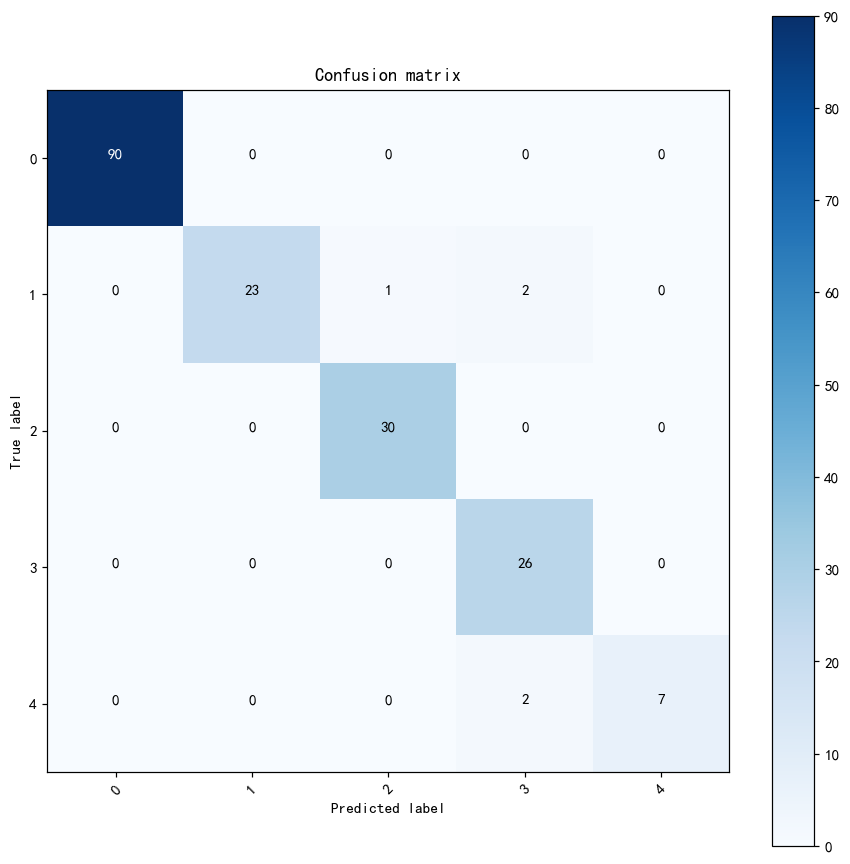

['0-喉', '1-上颚', '2-咽后壁', '3-右梨状窝', '4-左梨状窝']


In [12]:
K.set_learning_phase(0)
model = trainer.load_model(50)
# 加载训练中的最优模型
use_increase = False
# 显示预测准确度、混淆矩阵，保持混淆矩阵图到root_path
acc, y_pred, y_true, file_test,_ = trainer.predict_data([r"\\192.168.0.154\数据\口咽部\第7轮_整图\valid_date"], model = model)

path = Plot.show_matrix(y_pred, y_true, types_num, root_path, fig_size=10)
plt.show()
print(desc_list)

## EfficientNet推理

D:\Anaconda3\lib\site-packages\keras\backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '
2022-07-04 15:09:22,461 - INFO - trainer.py - load_model - 545 - load weights 200
2022-07-04 15:09:22,464 - DEBUG - images.py - sort_by_file_name - 354 - sort_by_file_name dirs=['0', '1', '2', '3', '4']


find 5 from \\192.168.0.154\数据\口咽部\第7轮_整图\valid_date
load data from fold finished ,count=181
6/6 [==============================] - 4s 237ms/step


2022-07-04 15:09:29,589 - DEBUG - colorbar.py - _get_ticker_locator_formatter - 847 - locator: <matplotlib.ticker.AutoLocator object at 0x000001CBD77F6460>
2022-07-04 15:09:29,734 - INFO - plot.py - show_matrix - 164 - save plot image to \\192.168.0.154\数据\口咽部\第8轮\2022-07-04-15-09_690.jpg 


cast105ms, fold: ['\\\\192.168.0.154\\数据\\口咽部\\第7轮_整图\\valid_date'] ,accurracy:99
Confusion matrix, without normalization


2022-07-04 15:09:29,736 - INFO - plot.py - show_matrix - 180 - accurracy:0.994475138121547


[[90  0  0  0  0]
 [ 0 25  1  0  0]
 [ 0  0 30  0  0]
 [ 0  0  0 26  0]
 [ 0  0  0  0  9]]
00 acc: 100.00%
01 acc: 96.15%
02 acc: 100.00%
03 acc: 100.00%
04 acc: 100.00%
overall acc: 99.45%, avg acc: 99.23%


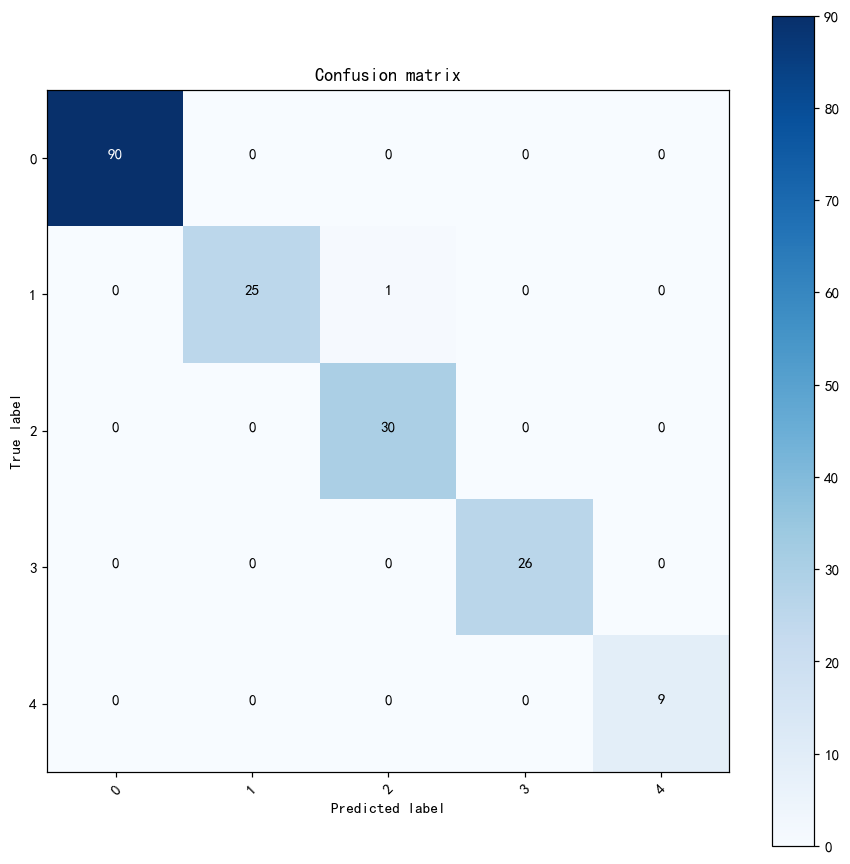

['0-喉', '1-上颚', '2-咽后壁', '3-右梨状窝', '4-左梨状窝']


In [9]:
K.set_learning_phase(0)
model_id = 200
model = trainer.load_model(model_id)
# 加载训练中的最优模型
use_increase = False
# 显示预测准确度、混淆矩阵，保持混淆矩阵图到root_path
acc, y_pred, y_true, file_test,_ = trainer.predict_data([r"\\192.168.0.154\数据\口咽部\第7轮_整图\valid_date"], model = model)

path = Plot.show_matrix(y_pred, y_true, types_num, root_path, fig_size=10)
plt.show()
print(desc_list)

## VGG16推理

D:\Anaconda3\lib\site-packages\keras\backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '
2022-07-04 15:10:20,175 - INFO - trainer.py - load_model - 545 - load weights 800
2022-07-04 15:10:20,178 - DEBUG - images.py - sort_by_file_name - 354 - sort_by_file_name dirs=['0', '1', '2', '3', '4']


find 5 from \\192.168.0.154\数据\口咽部\第7轮_整图\valid_date
load data from fold finished ,count=181
6/6 [==============================] - 4s 340ms/step


2022-07-04 15:10:26,865 - DEBUG - colorbar.py - _get_ticker_locator_formatter - 847 - locator: <matplotlib.ticker.AutoLocator object at 0x000001CBD3BC7FA0>
2022-07-04 15:10:27,008 - INFO - plot.py - show_matrix - 164 - save plot image to \\192.168.0.154\数据\口咽部\第8轮\2022-07-04-15-10_222.jpg 
2022-07-04 15:10:27,009 - INFO - plot.py - show_matrix - 180 - accurracy:0.9447513812154696


cast666ms, fold: ['\\\\192.168.0.154\\数据\\口咽部\\第7轮_整图\\valid_date'] ,accurracy:94
Confusion matrix, without normalization
[[90  0  0  0  0]
 [ 1 24  1  0  0]
 [ 0  2 28  0  0]
 [ 1  2  0 23  0]
 [ 0  2  0  1  6]]
00 acc: 100.00%
01 acc: 92.31%
02 acc: 93.33%
03 acc: 88.46%
04 acc: 66.67%
overall acc: 94.48%, avg acc: 88.15%


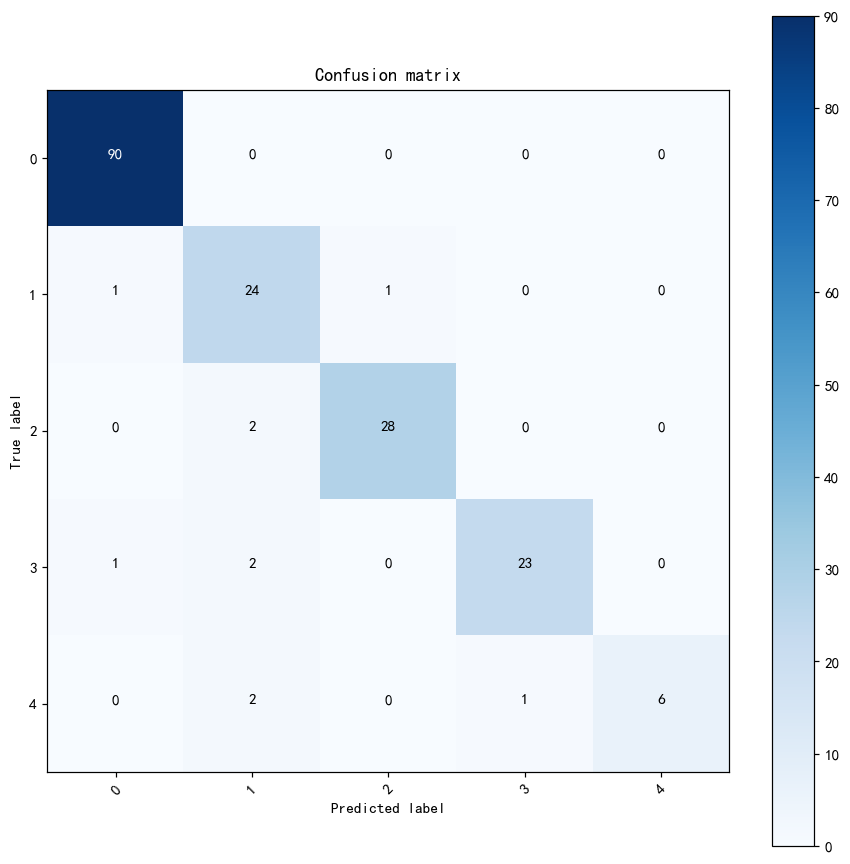

['0-喉', '1-上颚', '2-咽后壁', '3-右梨状窝', '4-左梨状窝']


In [10]:
K.set_learning_phase(0)
model_id = 800
model = trainer.load_model(model_id)
# 加载训练中的最优模型
use_increase = False
# 显示预测准确度、混淆矩阵，保持混淆矩阵图到root_path
acc, y_pred, y_true, file_test,_ = trainer.predict_data([r"\\192.168.0.154\数据\口咽部\第7轮_整图\valid_date"], model = model)

path = Plot.show_matrix(y_pred, y_true, types_num, root_path, fig_size=10)
plt.show()
print(desc_list)